# Importing relevant libraries

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import math

# Import Dataset

In [3]:
import pandas as pd

mitbih_train = pd.read_csv('data/mitbih_train.csv', header=None) 
mitbih_test = pd.read_csv('data/mitbih_test.csv', header=None)   

In [4]:
print(mitbih_train.shape)
print(mitbih_test.shape)

(87554, 188)
(21892, 188)


# Preprocessing Data

In [5]:
class ECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train,X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name} dataset:")
        classes = np.unique(y)
        for class_id in classes:
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"Class {class_id}: {count} samples ({percentage:.2f}%)")

    def preprocess_mitbih_data(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        #     # Split temp into validation and test sets
        #val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42
        )

        # Reshape for RNN input (batch_size, sequence_length, input_size)
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        return X_train, X_val, X_test, y_train, y_val, y_test

In [6]:
class ECGDataset(Dataset):
    """
    Custom Dataset class for ECG data
    """
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    test_dataset = ECGDataset(X_test, y_test)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, val_loader, test_loader

def plot_sample_signals(X, y, dataset_name, num_samples=3):
    """
    Plot sample ECG signals from each class
    """
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), num_samples, figsize=(15, 3*len(classes)))

    for i, class_id in enumerate(classes):
        # Get indices for current class
        class_indices = np.where(y == class_id)[0]
        # Randomly select samples
        sample_indices = np.random.choice(class_indices,
                                        min(num_samples, len(class_indices)),
                                        replace=False)

        for j, idx in enumerate(sample_indices):
            signal = X[idx].reshape(-1) if len(X[idx].shape) > 1 else X[idx]
            axes[i, j].plot(signal)
            axes[i, j].set_title(f'Class {class_id}')
            axes[i, j].set_xticks([])
            if j == 0:
                axes[i, j].set_ylabel('Amplitude')

    plt.suptitle(f'Sample ECG Signals from {dataset_name} Dataset')
    plt.tight_layout()
    plt.show()

In [7]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

processor = ECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Loading MIT-BIH dataset...
MIT-BIH dataset shape: (87554, 187)

Class distribution in MIT-BIH dataset:
Class 0.0: 72471 samples (82.77%)
Class 1.0: 2223 samples (2.54%)
Class 2.0: 5788 samples (6.61%)
Class 3.0: 641 samples (0.73%)
Class 4.0: 6431 samples (7.35%)

Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


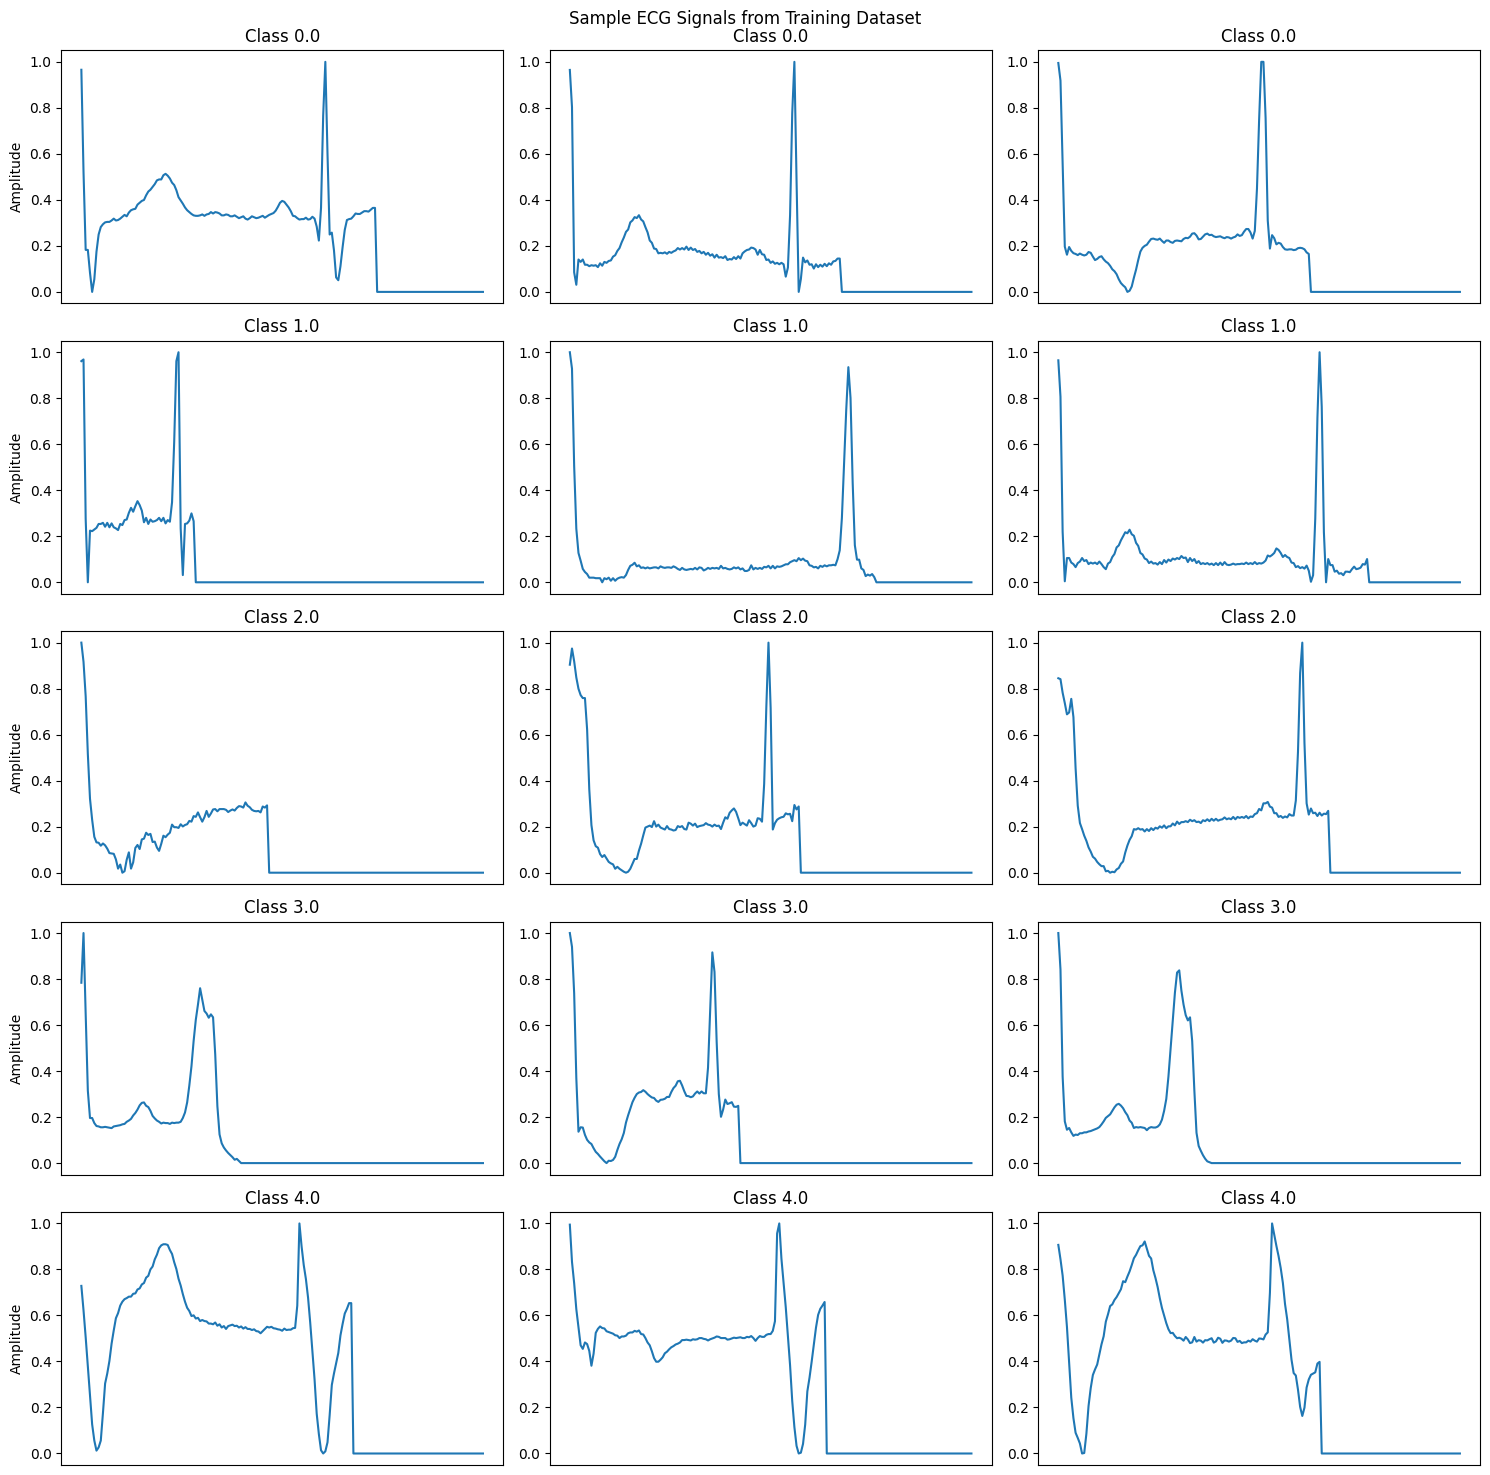


Final dataset sizes:
Training set: (78798, 187, 1)
Validation set: (8756, 187, 1)
Test set: (21892, 187, 1)


In [8]:
 # Create data loaders
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test
)

# Plot sample signals from each dataset
plot_sample_signals(X_train, y_train, "Training")

# Print final dataset sizes
print("\nFinal dataset sizes:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

### Helper Functions

In [9]:
class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""
    def __init__(self, patience=7, min_delta=0, verbose=True):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as an improvement
            verbose (bool): If True, prints a message for each validation loss improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_epoch = 0
        
    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_epoch = epoch
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                if self.verbose:
                    print(f'\nEarly stopping triggered! No improvement for {self.patience} epochs.')
                    print(f'Best validation loss: {self.best_loss:.4f} at epoch {self.best_epoch + 1}')
        else:
            self.best_loss = val_loss
            self.best_epoch = epoch
            self.counter = 0
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.4f}')

class CustomLRScheduler:
    def __init__(self, optimizer, initial_lr, max_lr, warmup_epochs, total_epochs):
        self.optimizer = optimizer
        self.initial_lr = initial_lr
        self.max_lr = max_lr
        self.warmup_epochs = warmup_epochs
        self.total_epochs = total_epochs
        self.current_epoch = 0

    def step(self):
        self.current_epoch += 1
        if self.current_epoch <= self.warmup_epochs:
            # Linear warmup
            lr = self.initial_lr + (self.max_lr - self.initial_lr) * (self.current_epoch / self.warmup_epochs)
        else:
            # Cosine annealing
            progress = (self.current_epoch - self.warmup_epochs) / (self.total_epochs - self.warmup_epochs)
            lr = self.initial_lr + 0.5 * (self.max_lr - self.initial_lr) * (1 + np.cos(progress * np.pi))

        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr

        return lr

class ModelTrainer:
    def __init__(self, model, model_name, device, criterion, config, early_stopping_patience=10):
        self.model = model.to(device)
        self.model_name = model_name
        self.device = device
        self.criterion = criterion
        self.config = config

        # Initialize optimizer with weight decay
        self.optimizer = optim.AdamW(
            self.model.parameters(),
            lr=config['initial_lr'],
            weight_decay=config['weight_decay']
        )

        # Initialize learning rate scheduler
        self.scheduler = CustomLRScheduler(
            self.optimizer,
            config['initial_lr'],
            config['max_lr'],
            config['warmup_epochs'],
            config['num_epochs']
        )

        # Initialize tracking metrics
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.best_val_loss = float('inf')
        
        # Initialize early stopping
        self.early_stopping = EarlyStopping(
            patience=early_stopping_patience,
            min_delta=0.0001,
            verbose=True
        )

        # Create directory for saving models
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        self.save_dir = os.path.join('models', f"{model_name}_{timestamp}")
        os.makedirs(self.save_dir, exist_ok=True)

    def train_epoch(self, train_loader):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        correct = 0
        total = 0

        for batch_X, batch_y in tqdm(train_loader, desc='Training'):
            batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

            self.optimizer.zero_grad()

            # Handle different model outputs
            if self.model_name == 'RNN':
                outputs, _ = self.model(batch_X)
            else:
                outputs = self.model(batch_X)

            loss = self.criterion(outputs, batch_y)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

            self.optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def validate(self, val_loader):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                loss = self.criterion(outputs, batch_y)
                total_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()

        epoch_loss = total_loss / len(val_loader)
        epoch_acc = 100 * correct / total
        return epoch_loss, epoch_acc

    def train(self, train_loader, val_loader, num_epochs):
        """Complete training process with early stopping"""
        print(f"\nStarting training for {self.model_name}...")
        print(f"Early stopping enabled with patience={self.early_stopping.patience}")

        for epoch in range(num_epochs):
            # Training phase
            train_loss, train_acc = self.train_epoch(train_loader)

            # Validation phase
            val_loss, val_acc = self.validate(val_loader)

            # Update learning rate
            self.scheduler.step()
            current_lr = self.optimizer.param_groups[0]['lr']

            # Save metrics
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_acc)
            self.val_accuracies.append(val_acc)

            # Print epoch results
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
            print(f'Learning Rate: {current_lr:.6f}')

            # Save best model
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.save_model('best_model.pth')
                print(f'✓ New best model saved! (Val Loss: {val_loss:.4f})')

            # Early stopping check
            self.early_stopping(val_loss, epoch)
            if self.early_stopping.early_stop:
                print(f'\n{"="*60}')
                print(f'Training stopped early at epoch {epoch+1}')
                print(f'Best validation loss: {self.early_stopping.best_loss:.4f}')
                print(f'Best epoch: {self.early_stopping.best_epoch + 1}')
                print(f'{"="*60}\n')
                break

        # Save final model
        self.save_model('final_model.pth')
        
        # Print training summary
        print(f'\n{"="*60}')
        print(f'Training Summary for {self.model_name}')
        print(f'{"="*60}')
        print(f'Total epochs trained: {len(self.train_losses)}')
        print(f'Best validation loss: {self.best_val_loss:.4f}')
        print(f'Final train accuracy: {self.train_accuracies[-1]:.2f}%')
        print(f'Final validation accuracy: {self.val_accuracies[-1]:.2f}%')
        print(f'{"="*60}\n')

    def save_model(self, filename):
        """Save model checkpoint"""
        path = os.path.join(self.save_dir, filename)
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'config': self.config,
            'best_val_loss': self.best_val_loss,
            'early_stopping_info': {
                'stopped_early': self.early_stopping.early_stop,
                'best_epoch': self.early_stopping.best_epoch,
                'patience': self.early_stopping.patience
            }
        }, path)

    def plot_training_history(self):
        """Plot training metrics with early stopping indicator"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

        epochs = range(1, len(self.train_losses) + 1)

        # Plot losses
        ax1.plot(epochs, self.train_losses, label='Training Loss', marker='o', markersize=3)
        ax1.plot(epochs, self.val_losses, label='Validation Loss', marker='s', markersize=3)
        
        # Mark best epoch
        best_epoch = self.early_stopping.best_epoch + 1
        if best_epoch <= len(self.val_losses):
            ax1.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax1.set_title(f'{self.model_name} - Training History (Loss)')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Plot accuracies
        ax2.plot(epochs, self.train_accuracies, label='Training Accuracy', marker='o', markersize=3)
        ax2.plot(epochs, self.val_accuracies, label='Validation Accuracy', marker='s', markersize=3)
        
        # Mark best epoch
        if best_epoch <= len(self.val_accuracies):
            ax2.axvline(x=best_epoch, color='r', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')
        
        ax2.set_title(f'{self.model_name} - Training History (Accuracy)')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy (%)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(os.path.join(self.save_dir, 'training_history.png'), dpi=300, bbox_inches='tight')
        plt.show()

    def evaluate(self, test_loader):
        self.model.eval()
        predictions = []
        true_labels = []

        with torch.no_grad():
            for batch_X, batch_y in tqdm(test_loader, desc='Testing'):
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)

                if self.model_name == 'RNN':
                    outputs, _ = self.model(batch_X)
                else:
                    outputs = self.model(batch_X)

                _, predicted = torch.max(outputs.data, 1)
                predictions.extend(predicted.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())

        # Print classification report
        print(f"\nClassification Report ({self.model_name}):")
        print(classification_report(true_labels, predictions))

        # Plot confusion matrix
        cm = confusion_matrix(true_labels, predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix ({self.model_name})')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.savefig(os.path.join(self.save_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
        plt.show()

# CNN From the Research Paper
https://arxiv.org/pdf/1805.00794

# Hyperparameter Tuning 

## CNN Architecture

In [10]:
class FinalResidualBlock(nn.Module):
    """
    Final residual block with validation
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, pool_size=5, pool_stride=2):
        super(FinalResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out

def calculate_output_length(input_length, kernel_size, stride, padding=0):
    """Calculate output length after conv/pool operation"""
    return math.floor((input_length + 2 * padding - kernel_size) / stride + 1)


def validate_architecture(sequence_length, num_res_blocks, pool_size, pool_stride):
    """
    Validate that the architecture won't cause sequence length to become 0
    
    Returns:
        (valid, final_length, error_message)
    """
    current_length = sequence_length
    
    for i in range(num_res_blocks):
        # After maxpool
        current_length = calculate_output_length(current_length, pool_size, pool_stride)
        
        if current_length <= 0:
            return False, 0, f"Sequence becomes 0 at block {i+1}/{num_res_blocks}"
    
    if current_length < 1:
        return False, current_length, "Final sequence length too small"
    
    return True, current_length, "Valid"

class FlexibleFinalCNN(nn.Module):
    """
    Flexible final CNN with validation to prevent pooling errors
    """
    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True):
        super(FlexibleFinalCNN, self).__init__()
        
        # Validate architecture before building
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build residual blocks dynamically
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                FinalResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride
                )
            )
            current_filters = out_filters
        
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers (paper-style: fc_neurons → fc_neurons → output)
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features after all residual blocks"""
        x = torch.randn(1, input_channels, sequence_length)
        
        for res_block in self.res_blocks:
            x = res_block(x)
        
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization for ReLU"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

## Random Search (Hyperparameter Tuning)

In [11]:
def train_and_evaluate_final(model, train_loader, val_loader, criterion, optimizer, 
                                   device, num_epochs=30, patience=10):
    """Train and evaluate model with early stopping"""
    model = model.to(device)
    best_val_acc = 0
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                total += batch_y.size(0)
                correct += (predicted == batch_y).sum().item()
        
        val_acc = 100 * correct / total
        
        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"  Early stopping at epoch {epoch+1}")
            break
    
    return best_val_acc

In [12]:
def random_search_final(X_train, X_val, X_test, y_train, y_val, y_test, 
                              n_iterations=50, constant_filters=True):
    """
    Random search with validation to skip invalid architectures
    """
    import random
    from torch.utils.data import DataLoader
    import torch.optim as optim
    
    # Define hyperparameter ranges with safer defaults
    param_ranges = {
        'num_filters': [16, 32, 64, 128],
        'kernel_size': [3, 5, 7, 9],
        'num_res_blocks': [2, 3, 4, 5],
        'pool_size': [2, 3, 5],      # Safer range
        'pool_stride': [2],           # Keep stride at 2 for safety
        'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
        'fc_neurons': [32, 64, 128, 256],
        'learning_rate': [1e-5, 5e-5, 1e-4, 5e-4, 1e-3],
        'batch_size': [32, 64, 128],
        'weight_decay': [0, 1e-5, 1e-4, 1e-3],
    }
    
    results = []
    best_val_acc = 0
    best_params = None
    skipped = 0
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    filter_mode = "CONSTANT" if constant_filters else "SCALING"
    
    print("="*70)
    print(f"RANDOM SEARCH: FINAL ARCHITECTURE ({filter_mode} FILTERS)")
    print("="*70)
    print(f"Iterations: {n_iterations}")
    print(f"Device: {device}")
    print(f"Dataset: {X_train.shape[0]} train, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Architecture: Final architecture with validation")
    print(f"Filter mode: {filter_mode}")
    print("="*70 + "\n")
    
    iteration = 0
    attempts = 0
    max_attempts = n_iterations * 3  # Allow some retries for invalid configs
    
    while iteration < n_iterations and attempts < max_attempts:
        attempts += 1
        
        # Randomly sample hyperparameters
        params = {
            key: random.choice(values) 
            for key, values in param_ranges.items()
        }
        
        # Validate architecture before creating model
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            skipped += 1
            print(f"⊘ Skipped invalid config: {msg} "
                  f"(blocks={params['num_res_blocks']}, pool={params['pool_size']}/{params['pool_stride']})")
            continue
        
        iteration += 1
        
        print(f"\n{'='*70}")
        print(f"Iteration {iteration}/{n_iterations} (Skipped: {skipped})")
        print(f"Filters: {params['num_filters']} ({filter_mode.lower()}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']} → final_len={final_len}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']} → {params['fc_neurons']} → {num_classes}")
        print(f"LR: {params['learning_rate']}, Batch: {params['batch_size']}, WD: {params['weight_decay']}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Train with early stopping
            val_acc = train_and_evaluate_final(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            # Store results
            result = {
                'params': params,
                'val_accuracy': val_acc,
                'iteration': iteration,
                'constant_filters': constant_filters,
                'architecture': 'final',
                'final_sequence_length': final_len
            }
            results.append(result)
            
            print(f"  ✓ Validation Accuracy: {val_acc:.2f}%")
            
            # Update best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = params.copy()
                print(f"  🎯 NEW BEST: {val_acc:.2f}%")
                
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            continue
    
    # Sort results by accuracy
    results_sorted = sorted(results, key=lambda x: x['val_accuracy'], reverse=True)
    
    # Print final results
    print(f"\n{'='*70}")
    print(f"RANDOM SEARCH COMPLETE - FINAL ARCHITECTURE ({filter_mode} FILTERS)")
    print(f"{'='*70}")
    print(f"Completed iterations: {len(results)}/{n_iterations}")
    print(f"Skipped invalid configs: {skipped}")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")
    print(f"\nBest parameters:")
    for key, value in best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}%")
        print(f"   {p['num_filters']} filters × {p['num_res_blocks']} blocks ({filter_mode.lower()})")
        print(f"   Kernel={p['kernel_size']}, Pool={p['pool_size']}/{p['pool_stride']}")
        print(f"   Dropout={p['dropout_rate']}, FC={p['fc_neurons']}→{p['fc_neurons']}→{num_classes}")
        print(f"   LR={p['learning_rate']}, Batch={p['batch_size']}, WD={p['weight_decay']}")
    
    print("="*70)
    
    return results, best_params, results_sorted

In [ ]:
results, best_params_random, results_sorted = random_search_final(
    X_train, X_val, X_test, 
    y_train, y_val, y_test,
    n_iterations=50, 
    constant_filters=True
)

RANDOM SEARCH: FINAL ARCHITECTURE (CONSTANT FILTERS)
Iterations: 50
Device: cuda
Dataset: 78798 train, 8756 val samples
Sequence length: 187, Classes: 5
Architecture: Final architecture with validation
Filter mode: CONSTANT


Iteration 1/50 (Skipped: 0)
Filters: 64 (constant) × 3 blocks
Kernel: 7, Pool: 2/2 → final_len=23
Dropout: 0.2, FC: 64 → 64 → 5
LR: 0.0005, Batch: 32, WD: 0.0001
  ✓ Validation Accuracy: 98.85%
  🎯 NEW BEST: 98.85%

Iteration 2/50 (Skipped: 0)
Filters: 16 (constant) × 4 blocks
Kernel: 9, Pool: 3/2 → final_len=10
Dropout: 0.2, FC: 256 → 256 → 5
LR: 5e-05, Batch: 32, WD: 0.0001


### Retraining CNN Model from Random Search

In [ ]:
def train_final_model(best_params, X_train, X_val, X_test, y_train, y_val, y_test,
                      constant_filters=True, combine_train_val=False,
                      num_epochs=50, warmup_epochs=5, early_stopping_patience=10):
    """
    Train final model with best hyperparameters and evaluate on test set
    
    Parameters:
    -----------
    best_params : dict
        Dictionary containing hyperparameters (num_filters, kernel_size, etc.)
    X_train, X_val, X_test : np.ndarray
        Training, validation, and test feature arrays
    y_train, y_val, y_test : np.ndarray
        Training, validation, and test label arrays
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    combine_train_val : bool, default=False
        If True, combines train and val data for final training (standard ML practice)
        If False, trains on train data only and validates on val data
    num_epochs : int, default=50
        Maximum number of training epochs
    warmup_epochs : int, default=5
        Number of warmup epochs for learning rate scheduler
    early_stopping_patience : int, default=10
        Early stopping patience (None to disable)
    
    Returns:
    --------
    dict containing:
        - 'model': trained model
        - 'trainer': ModelTrainer object with training history
        - 'test_accuracy': final test accuracy
        - 'best_params': hyperparameters used
        - 'save_dir': directory where results are saved
    """
    import torch
    import torch.nn as nn
    from torch.utils.data import DataLoader
    import numpy as np
    
    # Ensure pool_stride is in best_params
    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
    
    print("\n" + "="*70)
    if combine_train_val:
        print("TRAINING FINAL MODEL ON TRAIN+VAL DATA")
    else:
        print("TRAINING FINAL MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    # Setup device and data info
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Constant filters: {constant_filters}")
    
    # Prepare training data
    if combine_train_val:
        X_train_final = np.vstack([X_train, X_val])
        y_train_final = np.concatenate([y_train, y_val])
        print(f"Training samples: {X_train_final.shape[0]} (train+val combined)")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = False
    else:
        X_train_final = X_train
        y_train_final = y_train
        print(f"Training samples: {X_train_final.shape[0]}")
        print(f"Validation samples: {X_val.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = True
    
    # Create model
    best_model = FlexibleFinalCNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters
    )
    
    # Create data loaders
    train_loader = DataLoader(
        ECGDataset(X_train_final, y_train_final),
        batch_size=best_params['batch_size'],
        shuffle=True,
        num_workers=0
    )
    
    if use_validation:
        val_loader = DataLoader(
            ECGDataset(X_val, y_val),
            batch_size=best_params['batch_size'],
            num_workers=0
        )
    else:
        val_loader = None
    
    test_loader = DataLoader(
        ECGDataset(X_test, y_test),
        batch_size=best_params['batch_size'],
        num_workers=0
    )
    
    # Setup training configuration
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize the trainer
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleFinalCNN_BestModel',
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience if use_validation else None
    )
    
    # Train the model
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    # Plot training history
    print("\nGenerating training history plot...")
    trainer.plot_training_history()
    
    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Model and results saved to: {trainer.save_dir}")
    
    # Return results
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
        'save_dir': trainer.save_dir
    }

In [ ]:
final_results_random = train_final_model(
    best_params=best_params_random,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=True,  
    num_epochs=50,
    warmup_epochs=5,
    early_stopping_patience=10
)

In [ ]:
print("\n" + "="*70)
print("RANDOM SEARCH - FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (from search): {results_sorted[0]['val_accuracy']:.2f}%")
print(f"Final test accuracy: {final_results_random['test_accuracy']:.2f}%")
print(f"Results saved to: {final_results_random['save_dir']}")
print("="*70)

# Optuna for Hyperparameter Tuning

In [ ]:
import optuna

In [ ]:
def optuna_search_final(X_train, X_val, X_test, y_train, y_val, y_test,
                        n_trials=50, constant_filters=True):
    """
    Optuna-based hyperparameter search with pruning
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    def objective(trial):
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-5, 1e-3),
        }
        
        # Validate
        valid, final_len, msg = validate_architecture(
            sequence_length, params['num_res_blocks'], 
            params['pool_size'], params['pool_stride']
        )
        
        if not valid:
            raise optuna.exceptions.TrialPruned()
        
        try:
            # Create and train model
            model = FlexibleFinalCNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters
            )
            
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            val_acc = train_and_evaluate_final(
                model, train_loader, val_loader,
                criterion, optimizer, device,
                num_epochs=30,
                patience=10
            )
            
            return val_acc
            
        except Exception as e:
            print(f"Error: {e}")
            raise optuna.exceptions.TrialPruned()
    
    # Create study and optimize
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner()  # Prune bad trials early
    )
    
    study.optimize(objective, n_trials=n_trials)
    
    # Results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Best validation accuracy: {study.best_value:.2f}%")
    print(f"\nBest parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    # Convert to your format
    results_sorted = sorted(
        [{'params': t.params, 'val_accuracy': t.value} 
         for t in study.trials if t.value is not None],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    return study, study.best_params, results_sorted

In [ ]:
study, best_params_optuna, results_sorted_optuna = optuna_search_final(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_trials=50,
    constant_filters=True
)

## Retaining Best Model from Optuna

In [ ]:
final_results_optuna = train_final_model(
    best_params=best_params_optuna,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=True,  
    num_epochs=50,
    warmup_epochs=5,
    early_stopping_patience=10
)

In [ ]:
print("\n" + "="*70)
print("OPTUNA - FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (from search): {study.best_value:.2f}%")
print(f"Final test accuracy: {final_results_optuna['test_accuracy']:.2f}%")
print(f"Results saved to: {final_results_optuna['save_dir']}")
print("="*70)

In [ ]:
import optuna.visualization as vis
fig = vis.plot_optimization_history(study)
fig.show()

# Squeeze and Excitation Attention CNN

## CNN (with SE) Architecture

In [ ]:
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block
    """
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        
        # Squeeze: Global average pooling
        self.squeeze = nn.AdaptiveAvgPool1d(1)
        
        # Excitation: Two FC layers with bottleneck
        self.excitation = nn.Sequential(
            nn.Linear(channels, channels // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        batch_size, channels, _ = x.size()
        
        # Squeeze: [B, C, T] → [B, C, 1] → [B, C]
        y = self.squeeze(x).view(batch_size, channels)
        
        # Excitation: [B, C] → [B, C/r] → [B, C]
        y = self.excitation(y).view(batch_size, channels, 1)
        
        # Scale: Multiply attention weights with input
        return x * y.expand_as(x)


class SEResidualBlock(nn.Module):
    """
    Residual Block with SE Attention
    """
    def __init__(self, in_channels, out_channels, kernel_size=5, 
                 pool_size=5, pool_stride=2, reduction=16):
        super(SEResidualBlock, self).__init__()
        
        # First conv layer
        self.conv1 = nn.Conv1d(in_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU()
        
        # Second conv layer
        self.conv2 = nn.Conv1d(out_channels, out_channels, 
                               kernel_size=kernel_size, 
                               padding=kernel_size//2)
        self.bn2 = nn.BatchNorm1d(out_channels)
        
        # SE Attention Block
        self.se = SEBlock(out_channels, reduction=reduction)
        
        # Skip connection
        self.skip_connection = nn.Conv1d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()
        
        # ReLU after adding skip connection
        self.relu2 = nn.ReLU()
        
        # Max pooling
        self.pool = nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride)
        
    def forward(self, x):
        # Store input for skip connection
        identity = self.skip_connection(x)
        
        # First conv block
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        
        # Second conv block
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Apply SE attention
        out = self.se(out)
        
        # Add skip connection
        out = out + identity
        out = self.relu2(out)
        
        # Max pooling
        out = self.pool(out)
        
        return out


class FlexibleSECNN(nn.Module):

    def __init__(self, input_channels=1, num_classes=5, num_filters=32, 
                 kernel_size=5, num_res_blocks=5, pool_size=5, pool_stride=2,
                 fc_neurons=32, dropout_rate=0.3, sequence_length=187,
                 constant_filters=True, se_reduction=16):
        super(FlexibleSECNN, self).__init__()
        
        # Validate architecture
        valid, final_length, msg = validate_architecture(
            sequence_length, num_res_blocks, pool_size, pool_stride
        )
        
        if not valid:
            raise ValueError(
                f"Invalid architecture: {msg}\n"
                f"Input length: {sequence_length}, Blocks: {num_res_blocks}, "
                f"Pool: {pool_size}/{pool_stride}\n"
                f"Try: fewer blocks, smaller pool_size, or larger pool_stride"
            )
        
        self.num_res_blocks = num_res_blocks
        self.constant_filters = constant_filters
        
        # Build SE residual blocks
        self.res_blocks = nn.ModuleList()
        current_filters = input_channels
        
        for i in range(num_res_blocks):
            if constant_filters:
                out_filters = num_filters
            else:
                out_filters = min(num_filters * (2 ** (i // 2)), 256)
            
            self.res_blocks.append(
                SEResidualBlock(
                    current_filters, 
                    out_filters,
                    kernel_size=kernel_size,
                    pool_size=pool_size,
                    pool_stride=pool_stride,
                    reduction=se_reduction
                )
            )
            current_filters = out_filters
        
        # Dropout
        self.dropout = nn.Dropout(dropout_rate)
        
        # Calculate flattened feature size
        self._feature_size = self._get_feature_size(input_channels, sequence_length)
        
        # Fully connected layers
        self.fc1 = nn.Linear(self._feature_size, fc_neurons)
        self.relu_fc1 = nn.ReLU()
        
        self.fc2 = nn.Linear(fc_neurons, fc_neurons)
        self.relu_fc2 = nn.ReLU()
        
        # Output layer
        self.fc3 = nn.Linear(fc_neurons, num_classes)
        
        # Initialize weights
        self._init_weights()
    
    def _get_feature_size(self, input_channels, sequence_length):
        """Calculate the size of flattened features"""
        x = torch.randn(1, input_channels, sequence_length)
        for res_block in self.res_blocks:
            x = res_block(x)
        return x.view(1, -1).size(1)
    
    def _init_weights(self):
        """Initialize weights using He initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:  # ⭐ FIX
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        """Forward pass"""
        # Reshape for 1D convolution
        x = x.transpose(1, 2)
        
        # SE Residual blocks
        for res_block in self.res_blocks:
            x = res_block(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Fully connected layers
        x = self.fc1(x)
        x = self.relu_fc1(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu_fc2(x)
        x = self.dropout(x)
        
        # Output layer
        x = self.fc3(x)
        
        return x
    
    def count_parameters(self):
        """Count total and trainable parameters"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(f"\nModel Parameters:")
        print(f"Total parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        return total_params, trainable_params

In [ ]:
from optuna.pruners import MedianPruner
from optuna.samplers import TPESampler

def optuna_search_se_cnn(X_train, X_val, X_test, y_train, y_val, y_test,
                         n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna hyperparameter search for FlexibleSECNN
    
    Parameters:
    -----------
    X_train, X_val, X_test : np.ndarray
        Training, validation, and test data
    y_train, y_val, y_test : np.ndarray
        Training, validation, and test labels
    n_trials : int, default=50
        Number of trials to run
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    timeout : int, optional
        Time limit in seconds (None for no limit)
    
    Returns:
    --------
    tuple: (study, best_params, results_sorted)
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Dataset: {X_train.shape[0]} train, {X_val.shape[0]} val samples")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print(f"Timeout: {timeout if timeout else 'None'}")
    print("="*70 + "\n")
    
    def objective(trial):
        """Objective function for Optuna optimization"""
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,  # Fixed for stability
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': trial.suggest_categorical('batch_size', [32, 64, 128]),
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
            'se_reduction': trial.suggest_categorical('se_reduction', [4, 8, 16]),  # SE-specific
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid architecture - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} ({'constant' if constant_filters else 'scaling'}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"SE Reduction: {params['se_reduction']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleSECNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters,
                se_reduction=params['se_reduction']
            )
            
            model = model.to(device)
            
            # Create data loaders
            train_loader = DataLoader(
                ECGDataset(X_train, y_train),
                batch_size=params['batch_size'],
                shuffle=True,
                num_workers=0
            )
            val_loader = DataLoader(
                ECGDataset(X_val, y_val),
                batch_size=params['batch_size'],
                num_workers=0
            )
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with Optuna pruning
            num_epochs = 30
            patience = 10
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                # Report intermediate value for pruning
                trial.report(val_acc, epoch)
                
                # Optuna pruning: stop unpromising trials early
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                # Print progress every 5 epochs
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Validation Accuracy: {best_val_acc:.2f}%")
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise optuna.exceptions.TrialPruned()
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',  # Maximize validation accuracy
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)  # Reproducible results
    )
    
    # Run optimization
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    
    print(f"\nBest trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.2f}%")
    print(f"  Trial number: {best_trial.number}")
    
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    # Convert trials to results format
    results_sorted = sorted(
        [
            {
                'params': {**t.params, 'pool_stride': 2},  # Add fixed params
                'val_accuracy': t.value,
                'trial_number': t.number,
                'state': t.state.name
            }
            for t in study.trials 
            if t.value is not None
        ],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    # Print top 10
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}% (Trial {result['trial_number']})")
        print(f"   Filters: {p['num_filters']} × {p['num_res_blocks']} blocks")
        print(f"   Kernel: {p['kernel_size']}, Pool: {p['pool_size']}/{p['pool_stride']}")
        print(f"   SE Reduction: {p['se_reduction']}")
        print(f"   Dropout: {p['dropout_rate']}, FC: {p['fc_neurons']}")
        print(f"   LR: {p['learning_rate']:.2e}, Batch: {p['batch_size']}, WD: {p['weight_decay']:.2e}")
    
    print("="*70)
    
    # Prepare best_params for use with train_final_model
    best_params = {**best_trial.params, 'pool_stride': 2}
    
    return study, best_params, results_sorted

In [ ]:
study, best_params, results_sorted = optuna_search_se_cnn(
    X_train, X_val, X_test,
    y_train, y_val, y_test,
    n_trials=50,
    constant_filters=True
)

In [ ]:
def train_final_model_se(best_params, X_train, X_val, X_test, y_train, y_val, y_test,
                         constant_filters=True, combine_train_val=False,
                         num_epochs=50, warmup_epochs=5, early_stopping_patience=10):
    """
    Train final SE-CNN model with best hyperparameters
    (Same as train_final_model but uses FlexibleSECNN)
    """

    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
        
    if 'se_reduction' not in best_params:  
        best_params['se_reduction'] = 16   
    
    print("\n" + "="*70)
    if combine_train_val:
        print("TRAINING FINAL SE-CNN MODEL ON TRAIN+VAL DATA")
    else:
        print("TRAINING FINAL SE-CNN MODEL ON TRAIN DATA (VALIDATING ON VAL DATA)")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    # Setup device and data info
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    sequence_length = X_train.shape[1]
    num_classes = len(np.unique(y_train))
    
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Constant filters: {constant_filters}")
    
    # Prepare training data
    if combine_train_val:
        X_train_final = np.vstack([X_train, X_val])
        y_train_final = np.concatenate([y_train, y_val])
        print(f"Training samples: {X_train_final.shape[0]} (train+val combined)")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = False
    else:
        X_train_final = X_train
        y_train_final = y_train
        print(f"Training samples: {X_train_final.shape[0]}")
        print(f"Validation samples: {X_val.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}\n")
        use_validation = True
    
    # Create SE-CNN model
    best_model = FlexibleSECNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters,
        se_reduction=best_params['se_reduction']  # Now guaranteed to exist
    )
    
    # Create data loaders
    train_loader = DataLoader(
        ECGDataset(X_train_final, y_train_final),
        batch_size=best_params['batch_size'],
        shuffle=True,
        num_workers=0
    )
    
    if use_validation:
        val_loader = DataLoader(
            ECGDataset(X_val, y_val),
            batch_size=best_params['batch_size'],
            num_workers=0
        )
    else:
        val_loader = None
    
    test_loader = DataLoader(
        ECGDataset(X_test, y_test),
        batch_size=best_params['batch_size'],
        num_workers=0
    )
    
    # Setup training configuration
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize the trainer
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleSECNN_BestModel',  # ← Better name
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience if use_validation else None
    )
    
    # Train the model
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    # Plot training history
    print("\nGenerating training history plot...")
    trainer.plot_training_history()
    
    # Evaluate on test set
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Model and results saved to: {trainer.save_dir}")
    
    # Return results
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
        'save_dir': trainer.save_dir
    }

In [ ]:
final_results = train_final_model_se(
    best_params=best_params,
    X_train=X_train,
    X_val=X_val,
    X_test=X_test,
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    constant_filters=True,
    combine_train_val=True,  
    num_epochs=30
)

 ## Data Augmented Versions

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import os
from datetime import datetime
import optuna
import copy
import numpy as np
import torch
from optuna.exceptions import TrialPruned
from imblearn.over_sampling import SMOTE
from tsaug import TimeWarp, Drift, AddNoise

In [ ]:
import random

seed = 42

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [ ]:
incart_path = 'INCART 2-lead Arrhythmia Database.csv'
mitbih_train_path = 'data/mitbih_train.csv'
mitbih_test_path = 'data/mitbih_test.csv'

## Data Preprocessing: Hybrid sampling strategy 
## (Under-sampling + SMOTE Over-sampling)

In [ ]:
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

class NewECGDataProcessor:
    """
    Class to handle ECG data preprocessing for multiple datasets
    """
    def __init__(self, mitbih_train_path, mitbih_test_path, incart_path):
        self.mitbih_train_path = mitbih_train_path
        self.mitbih_test_path = mitbih_test_path
        self.incart_path = incart_path
        self.scaler = StandardScaler()

    def load_and_preprocess_mitbih(self):
        """
        Load and preprocess MIT-BIH test dataset
        """
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        print(f"MIT-BIH dataset shape: {X_train.shape}")
        self._print_class_distribution("MIT-BIH", y_train)

        return X_train, y_train, X_test, y_test

    def _print_class_distribution(self, dataset_name, y):
        """
        Print class distribution for a dataset
        """
        print(f"\nClass distribution in {dataset_name}:")
        classes = np.unique(y)
        for class_id in sorted(classes):
            count = np.sum(y == class_id)
            percentage = (count / len(y)) * 100
            print(f"  Class {int(class_id)}: {count:6d} samples ({percentage:5.2f}%)")
        print(f"  Total: {len(y)} samples")

    def preprocess_mitbih_data(self):
        print("Loading MIT-BIH dataset...")
        df_train = pd.read_csv(self.mitbih_train_path, header=None)
        df_test = pd.read_csv(self.mitbih_test_path, header=None)

        # Separate features and labels
        X_train = df_train.iloc[:, :-1].values
        y_train = df_train.iloc[:, -1].values
        X_test = df_test.iloc[:, :-1].values
        y_test = df_test.iloc[:, -1].values

        # Split before applying sampling methods
        X_train, X_val, y_train, y_val = train_test_split(
            X_train, y_train,
            test_size=0.1,
            random_state=42,
            stratify=y_train
        )

        # Print Initial class distributions
        self._print_class_distribution("INITIAL Training Set ", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Step 1: Undersample Class 0 first
        undersample_strategy = {
            0: 40000  # Reduce Class 0 only
        }
        
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
        X_train, y_train = rus.fit_resample(X_train, y_train)
        
        # Step 2: Oversample minority classes with SMOTE
        oversample_strategy = {
            1: 15000,  
            2: 8000,    
            3: 12000,   
            4: 10000    
        }
        
        smote = SMOTE(sampling_strategy=oversample_strategy, random_state=42, k_neighbors=5)
        X_train, y_train = smote.fit_resample(X_train, y_train)

        # Print final class distributions
        self._print_class_distribution("Training Set (after SMOTE + undersampling)", y_train)
        self._print_class_distribution("Validation Set", y_val)
        self._print_class_distribution("Test Set", y_test)

        # Reshape
        X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
        X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
        X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

        print(f"\nFinal dataset sizes:")
        print(f"Training set: {X_train.shape}")
        print(f"Validation set: {X_val.shape}")
        print(f"Test set: {X_test.shape}")

        return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
# Create processor instance
processor = NewECGDataProcessor(mitbih_train_path, mitbih_test_path, incart_path)

# Load and preprocess data
X_train, X_val, X_test, y_train, y_val, y_test = processor.preprocess_mitbih_data()

In [ ]:
print("Final dataset shape:")
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

## Data Augmentation

To improve model robustness and generalization, we applied the following augmentation techniques using the `tsaug` library:

### Methods Applied

1. **Additive Gaussian Noise**
   - Simulates electronic and thermal interference in ECG equipment
   - Noise scale: 0.01
   - Probability: 60%

2. **Baseline Wander (Drift)**
   - Models low-frequency drift caused by patient respiration and movement
   - Maximum drift: 0.15
   - Drift points: 5
   - Probability: 50%

3. **Time Warping**
   - Simulates natural variations in heart rate and recording speed
   - Speed changes: 3
   - Maximum speed ratio: 1.5
   - Probability: 30%

In [ ]:
from tsaug import AddNoise, Drift, TimeWarp
import numpy as np
import matplotlib.pyplot as plt

# Define all augmentation methods
def apply_augmentations_separately(X_train):
    
    augmentations = {}
    
    # Additive Noise
    print("\n1. Additive Noise (Gaussian):")
    noise_augmenter = AddNoise(scale=0.01)
    augmentations['noise'] = noise_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['noise'].shape}")
    
    # Baseline Wander (Drift)
    print("\n2. Baseline Wander( Drift):")
    drift_augmenter = Drift(max_drift=0.15, n_drift_points=5)
    augmentations['drift'] = drift_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['drift'].shape}")
    
    # Time Warping
    print("\n3. Time Warping:")
    warp_augmenter = TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    augmentations['warp'] = warp_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['warp'].shape}")
    
    # Combined
    print("\n4. Combined (Additive Noise + Baseline Wander + Time Warping) :")
    combined_augmenter = (
        AddNoise(scale=0.01) +
        Drift(max_drift=0.15, n_drift_points=5) +
        TimeWarp(n_speed_change=3, max_speed_ratio=1.5)
    )
    augmentations['combined'] = combined_augmenter.augment(X_train.squeeze()).reshape(X_train.shape)
    print(f"    Applied: {augmentations['combined'].shape}")
    
    return augmentations


def plot_overlay_noise_comparison(X_original, X_noisy, y, samples_per_class=2, figsize=(15, 10), figtitle=""):
    """
    Plot original vs augmented signals overlaid
    """
    classes = np.unique(y)
    n_classes = len(classes)
    
    fig, axes = plt.subplots(n_classes, samples_per_class, figsize=figsize)
    
    # Set title
    if figtitle:
        fig.suptitle(figtitle, fontsize=16, fontweight='bold')
    else:
        fig.suptitle('ECG Signals: Original (Blue) vs Augmented (Red)', fontsize=16, fontweight='bold')
    
    # Handle single row or column
    if n_classes == 1 and samples_per_class == 1:
        axes = np.array([[axes]])
    elif n_classes == 1:
        axes = axes.reshape(1, -1)
    elif samples_per_class == 1:
        axes = axes.reshape(-1, 1)
    
    for i, class_id in enumerate(classes):
        # Get indices for this class
        class_indices = np.where(y == class_id)[0]
        
        # Randomly select samples
        selected_indices = np.random.choice(class_indices, 
                                           size=min(samples_per_class, len(class_indices)), 
                                           replace=False)
        
        for j, idx in enumerate(selected_indices):
            ax = axes[i, j] if n_classes > 1 else axes[j]
            
            # Plot both signals overlaid
            signal_original = X_original[idx].squeeze()
            signal_noisy = X_noisy[idx].squeeze()
            
            ax.plot(signal_original, linewidth=1.0, color='blue', label='Original', alpha=0.7)
            ax.plot(signal_noisy, linewidth=0.8, color='red', label='Augmented', alpha=0.7)
            
            # Add class label on the left
            if j == 0:
                ax.set_ylabel(f'Class {int(class_id)}', fontsize=12, fontweight='bold')
            
            ax.set_title(f'Sample {j+1}', fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(loc='upper right', fontsize=8)
            
            # Remove x-axis labels except for bottom row
            if i < n_classes - 1:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel('Time Steps', fontsize=10)
    
    plt.tight_layout()
    plt.show()


augmentations = apply_augmentations_separately(X_train)

# 1. Additive Noise
print("\n1. Plotting Additive Noise...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['noise'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Additive Noise'
)

# 2. Baseline Wander
print("\n2. Plotting Baseline Wander...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['drift'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Baseline Wander (Drift)'
)

# 3. Time Warping
print("\n3. Plotting Time Warping...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['warp'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Time Warping'
)

# 4. Combined
print("\n4. Plotting Combined Augmentation...")
plot_overlay_noise_comparison(
    X_train, 
    augmentations['combined'], 
    y_train, 
    samples_per_class=2,
    figtitle='ECG Signals: Original vs Combined Augmentation (Noise + Drift + Warp)'
)

In [ ]:
# Added new class for augmented datasets and dataloaders

class ECGDataset(Dataset):

    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ECGDatasetAugmented(Dataset):
    """
    Custom Dataset class for ECG data with optional augmentation
    """
    def __init__(self, X, y, augment=False):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
        self.augment = augment
        
        if self.augment:
            self.augmenter = (
                AddNoise(scale=0.01) @ 0.6 +  # 60% probability
                Drift(max_drift=0.15, n_drift_points=5) @ 0.5 +  # 50% probability
                TimeWarp(n_speed_change=3, max_speed_ratio=1.5) @ 0.3  # 30% probability
            )

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]
        y = self.y[idx]
        
        if self.augment:
            x_numpy = x.numpy()
            x_aug = self.augmenter.augment(x_numpy.squeeze())
            x = torch.FloatTensor(x_aug.reshape(x_numpy.shape))
        
        return x, y


def create_data_loaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=32, augment_train=True):
    """
    Create train, validation, and test data loaders
    """
    # Create datasets - only augment training set
    train_dataset = ECGDatasetAugmented(X_train, y_train, augment=augment_train)
    val_dataset = ECGDatasetAugmented(X_val, y_val, augment=False)
    test_dataset = ECGDatasetAugmented(X_test, y_test, augment=False)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # Print class distributions
    print("\n" + "="*60)
    print("DATA LOADERS CREATED")
    print("="*60)
    
    print(f"\nDataLoader Information:")
    print(f"  Training batches: {len(train_loader)} (batch_size={batch_size}, augment={augment_train})")
    print(f"  Validation batches: {len(val_loader)} (batch_size={batch_size})")
    print(f"  Test batches: {len(test_loader)} (batch_size={batch_size})")

    return train_loader, val_loader, test_loader


# Create data loaders WITH augmentation
train_loader, val_loader, test_loader = create_data_loaders(
    X_train, X_val, X_test, y_train, y_val, y_test, 
    batch_size=32, 
    augment_train=True 
)

# Print final dataset sizes
print("\n" + "="*60)
print("FINAL DATASET SHAPES")
print("="*60)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

In [ ]:
# Verify augmentation is actually happening
print("\n" + "="*60)
print("VERIFYING DYNAMIC AUGMENTATION")
print("="*60)

# Check the dataset class being used
print(f"Training dataset class: {type(train_loader.dataset).__name__}")
print(f"Augmentation enabled: {train_loader.dataset.augment}")

# Get two batches and see if they're different (proof of dynamic augmentation)
train_iter = iter(train_loader)
batch1_X, _ = next(train_iter)
batch1_X_first_sample = batch1_X[0].numpy()

# Reset and get same batch again (will be different due to dynamic augmentation)
train_iter = iter(train_loader)
batch2_X, _ = next(train_iter)
batch2_X_first_sample = batch2_X[0].numpy()

# They should be different due to augmentation
difference = np.abs(batch1_X_first_sample - batch2_X_first_sample).mean()
print(f"\nDifference between two fetches of same sample: {difference:.6f}")
if difference > 0:
    print(" Dynamic augmentation is WORKING (samples are different)")
else:
    print(" No augmentation (samples are identical)")

In [ ]:
def optuna_search_se_cnn_with_aug(train_loader, val_loader, test_loader,
                                   n_trials=50, constant_filters=True, timeout=None):
    """
    Optuna hyperparameter search for FlexibleSECNN with pre-made augmented dataloaders
    
    Parameters:
    -----------
    train_loader : DataLoader
        Training data loader (with augmentation)
    val_loader : DataLoader
        Validation data loader (no augmentation)
    test_loader : DataLoader
        Test data loader (no augmentation)
    n_trials : int, default=50
        Number of trials to run
    constant_filters : bool, default=True
        Whether to use constant filters throughout the network
    timeout : int, optional
        Time limit in seconds (None for no limit)
    
    Returns:
    --------
    tuple: (study, best_params, results_sorted)
    """
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get data info from the loaders
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    
    # Get number of classes from dataset
    y_train = train_loader.dataset.y.numpy()
    num_classes = len(np.unique(y_train))
    
    print("="*70)
    print("OPTUNA HYPERPARAMETER SEARCH: FlexibleSECNN with Augmentation")
    print("="*70)
    print(f"Trials: {n_trials}")
    print(f"Device: {device}")
    print(f"Training batches: {len(train_loader)} (with augmentation)")
    print(f"Validation batches: {len(val_loader)}")
    print(f"Sequence length: {sequence_length}, Classes: {num_classes}")
    print(f"Filter mode: {'CONSTANT' if constant_filters else 'SCALING'}")
    print(f"Timeout: {timeout if timeout else 'None'}")
    print("="*70 + "\n")
    
    def objective(trial):
        """Objective function for Optuna optimization"""
        
        # Suggest hyperparameters
        params = {
            'num_filters': trial.suggest_categorical('num_filters', [16, 32, 64, 128]),
            'kernel_size': trial.suggest_categorical('kernel_size', [3, 5, 7, 9]),
            'num_res_blocks': trial.suggest_int('num_res_blocks', 2, 5),
            'pool_size': trial.suggest_categorical('pool_size', [2, 3, 5]),
            'pool_stride': 2,
            'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.5),
            'fc_neurons': trial.suggest_categorical('fc_neurons', [32, 64, 128, 256]),
            'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-3),
            'batch_size': train_loader.batch_size,  # Use existing batch size
            'weight_decay': trial.suggest_loguniform('weight_decay', 1e-6, 1e-3),
            'se_reduction': trial.suggest_categorical('se_reduction', [4, 8, 16]),
        }
        
        # Validate architecture
        valid, final_len, msg = validate_architecture(
            sequence_length, 
            params['num_res_blocks'], 
            params['pool_size'], 
            params['pool_stride']
        )
        
        if not valid:
            print(f"⊘ Trial {trial.number}: Invalid architecture - {msg}")
            raise optuna.exceptions.TrialPruned()
        
        print(f"\n{'='*70}")
        print(f"Trial {trial.number}")
        print(f"{'='*70}")
        print(f"Filters: {params['num_filters']} ({'constant' if constant_filters else 'scaling'}) × {params['num_res_blocks']} blocks")
        print(f"Kernel: {params['kernel_size']}, Pool: {params['pool_size']}/{params['pool_stride']}")
        print(f"SE Reduction: {params['se_reduction']}")
        print(f"Dropout: {params['dropout_rate']}, FC: {params['fc_neurons']}")
        print(f"LR: {params['learning_rate']:.2e}, Batch: {params['batch_size']}, WD: {params['weight_decay']:.2e}")
        print(f"{'='*70}")
        
        try:
            # Create model
            model = FlexibleSECNN(
                input_channels=1,
                num_classes=num_classes,
                num_filters=params['num_filters'],
                kernel_size=params['kernel_size'],
                num_res_blocks=params['num_res_blocks'],
                pool_size=params['pool_size'],
                pool_stride=params['pool_stride'],
                fc_neurons=params['fc_neurons'],
                dropout_rate=params['dropout_rate'],
                sequence_length=sequence_length,
                constant_filters=constant_filters,
                se_reduction=params['se_reduction']
            )
            
            model = model.to(device)
            
            # Setup training
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
            
            # Training loop with Optuna pruning
            num_epochs = 30
            patience = 10
            best_val_acc = 0
            epochs_no_improve = 0
            
            for epoch in range(num_epochs):
                # Training
                model.train()
                train_loss = 0
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    train_loss += loss.item()
                
                # Validation
                model.eval()
                correct = 0
                total = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                        outputs = model(batch_X)
                        _, predicted = torch.max(outputs.data, 1)
                        total += batch_y.size(0)
                        correct += (predicted == batch_y).sum().item()
                
                val_acc = 100 * correct / total
                
                # Report intermediate value for pruning
                trial.report(val_acc, epoch)
                
                # Optuna pruning
                if trial.should_prune():
                    print(f"  ✂️ Pruned at epoch {epoch+1}")
                    raise optuna.exceptions.TrialPruned()
                
                # Early stopping
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                
                if epochs_no_improve >= patience:
                    print(f"  Early stopping at epoch {epoch+1}")
                    break
                
                if (epoch + 1) % 5 == 0:
                    print(f"  Epoch {epoch+1}/{num_epochs}: Val Acc = {val_acc:.2f}%")
            
            print(f"  ✓ Final Validation Accuracy: {best_val_acc:.2f}%")
            
            return best_val_acc
            
        except optuna.exceptions.TrialPruned:
            raise
        except Exception as e:
            print(f"  ✗ Error: {str(e)}")
            import traceback
            traceback.print_exc()
            raise optuna.exceptions.TrialPruned()
    
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=10),
        sampler=TPESampler(seed=42)
    )
    
    # Run optimization
    study.optimize(
        objective, 
        n_trials=n_trials,
        timeout=timeout,
        show_progress_bar=True
    )
    
    # Print results
    print(f"\n{'='*70}")
    print(f"OPTUNA OPTIMIZATION COMPLETE")
    print(f"{'='*70}")
    print(f"Number of finished trials: {len(study.trials)}")
    print(f"Number of pruned trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED])}")
    print(f"Number of complete trials: {len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])}")
    
    print(f"\nBest trial:")
    best_trial = study.best_trial
    print(f"  Value (Validation Accuracy): {best_trial.value:.2f}%")
    print(f"  Trial number: {best_trial.number}")
    
    print(f"\nBest hyperparameters:")
    print(f"{'='*70}")
    for key, value in best_trial.params.items():
        print(f"  {key:20s}: {value}")
    print(f"{'='*70}")
    
    # Convert trials to results format
    results_sorted = sorted(
        [
            {
                'params': {**t.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size},
                'val_accuracy': t.value,
                'trial_number': t.number,
                'state': t.state.name
            }
            for t in study.trials 
            if t.value is not None
        ],
        key=lambda x: x['val_accuracy'],
        reverse=True
    )
    
    # Print top 10
    print(f"\n{'='*70}")
    print(f"Top 10 Configurations:")
    print(f"{'='*70}")
    for i, result in enumerate(results_sorted[:10], 1):
        p = result['params']
        print(f"\n{i}. Val Acc: {result['val_accuracy']:.2f}% (Trial {result['trial_number']})")
        print(f"   Filters: {p['num_filters']} × {p['num_res_blocks']} blocks")
        print(f"   Kernel: {p['kernel_size']}, Pool: {p['pool_size']}/{p['pool_stride']}")
        print(f"   SE Reduction: {p['se_reduction']}")
        print(f"   Dropout: {p['dropout_rate']}, FC: {p['fc_neurons']}")
        print(f"   LR: {p['learning_rate']:.2e}, Batch: {p['batch_size']}, WD: {p['weight_decay']:.2e}")
    
    print("="*70)
    
    # Prepare best_params
    best_params = {**best_trial.params, 'pool_stride': 2, 'batch_size': train_loader.batch_size}
    
    return study, best_params, results_sorted

In [ ]:
study, best_params, results_sorted = optuna_search_se_cnn_with_aug(
    train_loader=train_loader,  # ← Augmented training data
    val_loader=val_loader,       # ← No augmentation
    test_loader=test_loader,     # ← No augmentation (not used in search)
    n_trials=50,
    constant_filters=True,
    timeout=None
)

In [ ]:
def train_final_model_se_with_loaders(best_params, train_loader, val_loader, test_loader,
                                       constant_filters=True, num_epochs=50, 
                                       warmup_epochs=5, early_stopping_patience=10):
    """
    Train final SE-CNN model with pre-made dataloaders (supports augmentation)
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Get info from loaders
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    num_classes = len(torch.unique(train_loader.dataset.y))
    
    print("\n" + "="*70)
    print("TRAINING FINAL SE-CNN MODEL")
    print("="*70)
    print(f"\nBest Hyperparameters:")
    for key, value in best_params.items():
        print(f"  {key:20s}: {value}")
    print("="*70 + "\n")
    
    print(f"Device: {device}")
    print(f"Sequence length: {sequence_length}")
    print(f"Number of classes: {num_classes}")
    print(f"Training batches: {len(train_loader)} (with augmentation)")
    print(f"Validation batches: {len(val_loader) if val_loader else 0}")
    print(f"Test batches: {len(test_loader)}\n")
    
    # Ensure required params
    if 'pool_stride' not in best_params:
        best_params['pool_stride'] = 2
    if 'se_reduction' not in best_params:
        best_params['se_reduction'] = 16
    
    # Create model
    best_model = FlexibleSECNN(
        input_channels=1,
        num_classes=num_classes,
        num_filters=best_params['num_filters'],
        kernel_size=best_params['kernel_size'],
        num_res_blocks=best_params['num_res_blocks'],
        pool_size=best_params['pool_size'],
        pool_stride=best_params['pool_stride'],
        fc_neurons=best_params['fc_neurons'],
        dropout_rate=best_params['dropout_rate'],
        sequence_length=sequence_length,
        constant_filters=constant_filters,
        se_reduction=best_params['se_reduction']
    )
    
    # Setup training configuration
    config = {
        'initial_lr': best_params['learning_rate'],
        'max_lr': best_params['learning_rate'] * 2,
        'warmup_epochs': warmup_epochs,
        'num_epochs': num_epochs,
        'weight_decay': best_params['weight_decay']
    }
    
    criterion = nn.CrossEntropyLoss()
    
    # Initialize trainer
    trainer = ModelTrainer(
        model=best_model,
        model_name='FlexibleSECNN_BestModel',
        device=device,
        criterion=criterion,
        config=config,
        early_stopping_patience=early_stopping_patience if val_loader else None
    )
    
    # Train
    print("Starting training...")
    trainer.train(train_loader, val_loader, num_epochs=config['num_epochs'])
    
    # Plot
    print("\nGenerating training history plot...")
    trainer.plot_training_history()
    
    # Evaluate
    print("\n" + "="*70)
    print("EVALUATING ON TEST SET")
    print("="*70 + "\n")
    test_results = trainer.evaluate(test_loader)
    
    print(f"\n✓ Model and results saved to: {trainer.save_dir}")
    
    return {
        'model': best_model,
        'trainer': trainer,
        'test_accuracy': test_results['accuracy'],
        'test_results': test_results,
        'best_params': best_params,
        'save_dir': trainer.save_dir
    }

In [ ]:
final_results = train_final_model_se_with_loaders(
    best_params=best_params,
    train_loader=train_loader,  
    val_loader=val_loader,
    test_loader=test_loader,
    constant_filters=True,
    num_epochs=50
)

In [ ]:
print("\n" + "="*70)
print("FINAL RESULTS")
print("="*70)
print(f"Best validation accuracy (search): {study.best_value:.2f}%")
print(f"Final test accuracy: {final_results['test_accuracy']:.2f}%")
print(f"Model saved to: {final_results['save_dir']}")
print("="*70)